In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, ReLU, BatchNormalization,Add, AveragePooling1D, Flatten, Dense
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow import Tensor

pd.options.display.max_columns = 100

In [208]:
def create_res_net():
    input_shape = len(X_train[0])
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer with linear activation
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

In [274]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv1D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Dropout(.6)(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
    if downsample:
        x = Conv1D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    out = Dropout(.6)(out)
    
    return out

def create_res_net():
    
    inputs = Input(shape=(X_train.shape[1],))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv1D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(inputs)
    t = relu_bn(t)
    t = Dropout(.6)(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    t = AveragePooling1D(3)(t)
    t = Flatten()(t)
    t = Dense(64, activation="relu", kernel_initializer="glorot_uniform")(inputs)
    f1 = Dense(32, activation="relu")(t)
    f2 = Dense(16, activation="relu")(f1)
    f3 = Dense(8, activation="relu")(f2)
    outputs = Dense(1, activation='linear')(f3)
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mean_squared_error',
        metrics=['accuracy']
    )
    return model    

In [275]:
# read in data
df = pd.read_csv("liverData/eldd.csv")

In [276]:
# print length and show sample data
print(len(df))
df.head()

654


,Age,Sex,DaysAtRisk,Deceased,LTx,Cirrhosis,ALF,Ethyltoxic,HBV,HCV,AIH,PBC,PSC,NASH,Cryptogenic,Dialysis,GIB,HCC,SBP,ALAT_S,ALB_S,AP_S,ASAT_S,B_MPV_E,B_PLT_E,B_WBC_E,BILI_S,BILID_S,CA_S,CHE_S,CHOLG_S,CL_S,CRE_S,CRP_S,CYSC_S,GGT_S,IL6_S,INR_C,NA_S,P_S,PALB_S,PROT_S,PTH_S,VDT_OH_S
0,68,male,200,0,0,1.0,0,1,1,0,0,0,0,0,0,0.0,0,1,0.0,0.29,40.9,1.17,0.56,11.0,160.0,7.4,7.9,3.5,2.17,74.6,3.08,100.3,104,8.20,1.79,1.97,22.87,1.11,135.4,1.49,0.19,69.6,2.39,12.7
1,64,male,3,1,0,1.0,0,1,0,0,0,0,0,0,0,0.0,1,0,0.0,0.22,28.3,3.68,0.66,NaN,10.0,8.1,43.2,26.0,2.04,14.7,2.21,101.9,304,43.54,4.87,2.43,336.50,1.77,133.1,0.96,0.05,62.5,19.39,5.5
2,67,female,208,0,0,1.0,0,1,0,0,0,0,0,0,0,0.0,0,0,0.0,0.19,41.7,1.50,0.68,10.8,123.0,4.9,16.9,6.9,2.33,59.5,5.02,93.8,95,9.88,2.23,1.84,16.74,1.09,137.4,1.14,0.17,80.5,7.39,18.8
3,32,female,17,1,0,0.0,1,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0.78,23.8,52.97,3.24,NaN,NaN,NaN,266.5,208.3,2.23,15.4,4.55,95.7,61,90.29,4.73,24.35,709.80,2.29,130.5,1.71,0.15,48.9,2.21,4.5
4,64,female,189,0,0,1.0,0,1,0,0,0,0,0,0,0,0.0,1,0,0.0,0.75,36.3,2.79,1.33,13.9,65.0,6.3,37.2,16.9,2.28,63.8,4.78,100.8,73,8.65,1.51,2.45,7.90,1.10,142.6,1.07,0.11,67.6,4.17,34.1


In [277]:
#meld functions
#https://www.mdcalc.com/calc/10437/model-end-stage-liver-disease-meld#evidence

import math

# TODO: check all SI values and see what needs conversion. Sodium did not, unknown after Bili but placeholder functions added
#convert SI units to US units
#creatinine umol/L to mg/dl
def convertCreatinine(CRE_S):
     return (CRE_S * 0.0230)
#bilirubin umol/L to mg/dl
def convertBilirubin(BILI_S):
     return (BILI_S * 0.0585)
#bilirubin umol/L to mg/dl
def convertCystatinC(BILI_S):
     return (BILI_S * 0.0585)
#bilirubin umol/L to mg/dl
def convertIL_6(BILI_S):
     return (BILI_S * 0.0585)
#bilirubin umol/L to mg/dl
def convertWBC(BILI_S):
     return (BILI_S * 0.0585)
#bilirubin umol/L to mg/dl
def convertProtien(BILI_S):
     return (BILI_S * 0.0585)
def convertAlbumin(BILI_S):
     return (BILI_S * 0.0585)
def convertALAT(BILI_S):
     return (BILI_S * 0.0585)
def convertASAT(BILI_S):
     return (BILI_S * 0.0585)

#meld3
#1.33*(Female) + 4.56*ln(Serum bilirubin) + 0.82*(137 - Sodium) – 0.24*(137 - Sodium)*ln(Serum bilirubin) + 9.09*ln(INR) + 11.14*ln(Serum creatinine) + 1.85*(3.5 – Serum albumin) – 1.83*(3.5 – Serum albumin)*ln(Serum creatinine) + 6,
#rounded to the nearest integer
#Serum bilirubin, INR, and serum creatinine values below 1.0 are set to 1.0.
#Sodium is limited to a range of 125-137 mEq/L, and if outside of these bounds, is set to the nearest limit.
#Serum albumin is limited to a range of 1.5-3.5 g/dL, and if outside of these bounds, is set to the nearest limit.
#Maximum serum creatinine is 3.0 mg/dL, and if above this bound, is set to 3.0 mg/dL.

def calm_meld(CRE_S, BILI_S, INR_C):
    meld_score = (0.957*math.log(convertCreatinine(CRE_S)) + 0.378*math.log(convertBilirubin(BILI_S)) + 1.120*math.log(INR_C) + 0.643)*10
    return int(round(meld_score))

def calc_meld3(CRE_S, BILI_S, INR_C, NA_S, ALB_S, sex):
    BILI_S = convertBilirubin(BILI_S)
    CRE_S = convertCreatinine(CRE_S)
    if BILI_S < 1:
        BILI_S = 1
    if INR_C < 1:
        INR_C = 1
    if CRE_S < 1:
        CRE_S = 1
    if CRE_S >= 3:
        CRE_S = 3
    if NA_S > 137:
        NA_S = 137
    if NA_S < 125:
        NA_S = 125
    if ALB_S > 3.5:
        ALB_S = 3.5
    if ALB_S < 1.5:
        ALB_S = 1.5
    if sex == 'female':
        sex = 1
    else:
        sex = 0
    
    meld3_score = 1.33*(sex) + 4.56*math.log(BILI_S) + 0.82*(137 - NA_S) - 0.24*(137 - NA_S)*math.log(BILI_S) + 9.09*math.log(INR_C) + 11.14*math.log(CRE_S) + 1.85*(3.5 - ALB_S) - 1.83*(3.5 - ALB_S)*math.log(CRE_S) + 6
    return int(round(meld3_score))

#meld_na
#MELD(i) = 0.957*ln(Creatinine) + 0.378*ln(Bilirubin) + 1.120*ln(INR) + 0.643
#Then, round to the tenth decimal place and multiply by 10. 
#If MELD(i) > 11, perform additional MELD calculation as follows:
#MELD = MELD(i) + 1.32*(137 – Na) –  [0.033*MELD(i)*(137 – Na)]

def calc_meldNA(CRE_S, BILI_S, INR_C,NA_S):
    meldNA_score = 0.957 * math.log(convertCreatinine(CRE_S)) + 0.378*math.log(convertBilirubin(BILI_S)) + 1.120*math.log(INR_C) + 0.643
    meldNA_score = round(meldNA_score, 1) * 10
    if meldNA_score > 11:
        meldNA_score = meldNA_score + 1.32*(137-NA_S) - (0.033*meldNA_score*(137-NA_S))
    return int(round(meldNA_score))


In [278]:
#Data preprocessing
#drop NA rows to allow for meld scores. 654 down to 638
df = df.dropna(subset=['INR_C','NA_S','ALB_S'])

#TODO: convert SI to metric as necessary
#US hospital labs are in metric is why we're converting here.


In [279]:
df2 = df.copy(deep=True).reset_index(drop=True)
df2['MELD'] = df2.apply(lambda row: calm_meld(row["CRE_S"],row["BILI_S"],row["INR_C"]), axis =1)
df2['MELD3'] = df2.apply(lambda row: calc_meld3(row["CRE_S"],row["BILI_S"],row["INR_C"],row["NA_S"],row["ALB_S"],row["Sex"]), axis =1)
df2['MELDNA'] = df2.apply(lambda row: calc_meldNA(row["CRE_S"],row["BILI_S"],row["INR_C"],row["NA_S"]), axis =1)


In [280]:
# one-hot encode Sex
col = pd.get_dummies(df2['Sex'])
del df2['Sex']
df2 = df2.join(col)

# take out MELD score comparisons for final_df
final_df = df2.copy(deep=True)
# del final_df["MELD"]
# del final_df["MELD3"]
# del final_df["MELDNA"]

# Assumption: all null numeric values are 0
final_df = final_df.replace(np.NaN, 0)

final_df_normalized = final_df.copy(deep=True)

# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# scaler = StandardScaler()
# non_binary_cols = [col for col in final_df.columns if len(final_df[col].unique()) > 2]
# binary_cols = [col for col in final_df.columns if len(final_df[col].unique()) <= 2]
# final_df_normalized = pd.DataFrame(scaler.fit_transform(final_df[non_binary_cols]), columns=non_binary_cols)
# final_df_normalized = pd.concat([final_df[binary_cols], final_df_normalized], axis=1)

In [281]:
from sklearn.model_selection import train_test_split

#Goal of improving on original meld for now. 
#Meld3 is used primarily for transplant, meldNA is used for Cirrhosis: #https://www.mdcalc.com/calc/10437/model-end-stage-liver-disease-meld#evidence
y = final_df_normalized['MELD'].copy(deep=True)

#Trim columns to use for training
#Removing days at risk, deceased, 
#fields = ['Age','Sex','Cirrhosis','ALF','Ethyltoxic','HBV','HCV','INR_C','NA_S','P_S','','','','']
del final_df_normalized["MELD"]
X = final_df_normalized.copy(deep=True)

# from imblearn.under_sampling import RandomUnderSampler
# under_sample = RandomUnderSampler(sampling_strategy = 1)
# X_under, y_under = under_sample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [282]:
model = create_res_net()
model.fit(x=X_train,
    y=y_train,
    epochs=500,
    verbose=1,
    validation_data=(X_test, y_test),
    batch_size=32)

ValueError: Input 0 of layer "conv1d_257" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 47)

In [265]:
y_pred = model.predict(X_test)

In [272]:
y_pred.shape

(128, 47, 1)

In [273]:
y_pred

array([[[19.043941],
        [16.541235],
        [16.541235],
        ...,
        [19.188425],
        [15.48894 ],
        [16.541235]],

       [[18.562334],
        [20.180098],
        [16.541235],
        ...,
        [20.00717 ],
        [15.48894 ],
        [16.541235]],

       [[18.225199],
        [16.541235],
        [15.48894 ],
        ...,
        [19.676523],
        [16.541235],
        [15.48894 ]],

       ...,

       [[19.188425],
        [12.57731 ],
        [15.48894 ],
        ...,
        [19.875845],
        [15.48894 ],
        [16.541235]],

       [[18.995783],
        [12.649014],
        [15.48894 ],
        ...,
        [20.323895],
        [15.48894 ],
        [16.541235]],

       [[18.803137],
        [14.321838],
        [15.48894 ],
        ...,
        [19.676523],
        [15.48894 ],
        [16.541235]]], dtype=float32)

(array([ 13.,  34.,  40.,  92., 102.,  86.,  67.,  62.,  33.,  31.,  25.,
         12.,  18.,   7.,   3.,   6.,   2.,   2.,   2.,   1.]),
 array([ 2.  ,  4.65,  7.3 ,  9.95, 12.6 , 15.25, 17.9 , 20.55, 23.2 ,
        25.85, 28.5 , 31.15, 33.8 , 36.45, 39.1 , 41.75, 44.4 , 47.05,
        49.7 , 52.35, 55.  ]),
 <BarContainer object of 20 artists>)

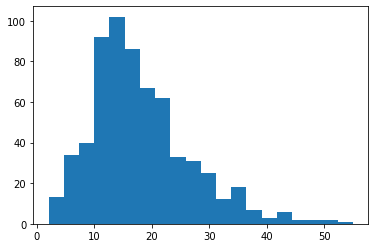

In [269]:
plt.hist(y, bins=20)

ValueError: x must have 2 or fewer dimensions

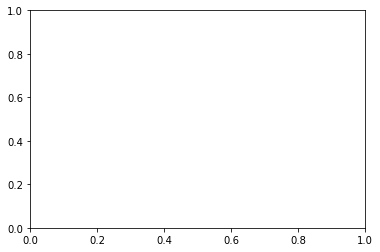

In [270]:
plt.hist(y_pred, bins=20)

(array([ 2.,  4.,  5.,  1.,  2., 12.,  2.,  6., 13.,  9.,  9., 12., 14.,
         9., 10.,  8.,  2.,  2.,  4.,  1.]),
 array([781. , 782.7, 784.4, 786.1, 787.8, 789.5, 791.2, 792.9, 794.6,
        796.3, 798. , 799.7, 801.4, 803.1, 804.8, 806.5, 808.2, 809.9,
        811.6, 813.3, 815. ]),
 <BarContainer object of 20 artists>)

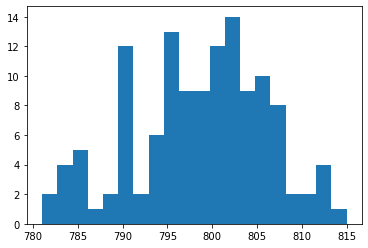

In [271]:
plt.hist(meld_pred, bins=20)

In [ ]:
#TODO: custom accuracy metric. Not trying to match current meld value, but to prove our model is 
#      generating a better measure of short term survivability. 

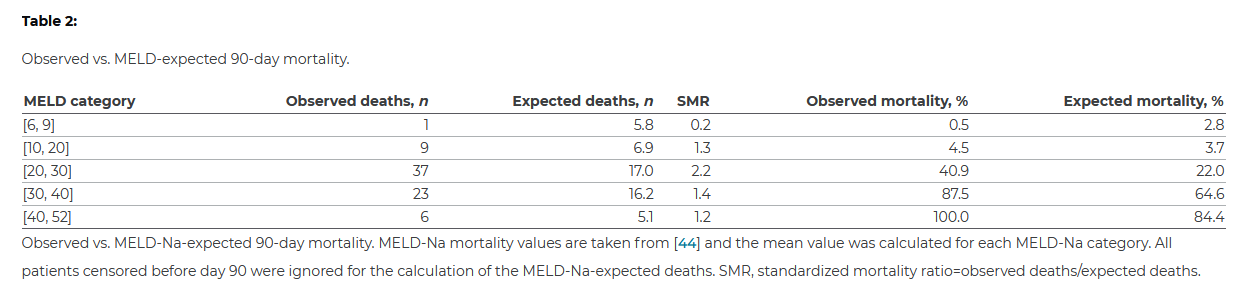